In [1]:
import os

import doctest
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()


from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
  
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import Imputer 
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
PATH = 'data/'

import torch
import gc
%matplotlib inline

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
#torch.backends.cudnn.deterministic = True
#torch.manual_seed(999)

# Get Data

In [3]:
train = pd.read_csv('data/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('data/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

# Folding

# Feature engineering

In [4]:
'''for df in [train, test]:
    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60
    
#     df['max_visits'] = df['fullVisitorId'].map(
#         df[['fullVisitorId', 'visitNumber']].groupby('fullVisitorId')['visitNumber'].max()
#     )
    
    df['nb_pageviews'] = df['date'].map(
        df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()
    )
    
    df['ratio_pageviews'] = df['totals.pageviews'] / df['nb_pageviews']
    
#     df['nb_sessions'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_sessions_28_ma'] = df['date'].map(
#         df[['date']].groupby('date').size().rolling(28, min_periods=7).mean()
#     )

#     df['nb_sessions_28_ma'] = df['nb_sessions'] / df['nb_sessions_28_ma']

#     df['nb_sessions_per_day'] = df['date'].map(
#         df[['date']].groupby('date').size()
#     )
    
#     df['nb_visitors_per_day'] = df['date'].map(
#         df[['date','fullVisitorId']].groupby('date')['fullVisitorId'].nunique()
#     )'''

"for df in [train, test]:\n    df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')\n    df['sess_date_dow'] = df['vis_date'].dt.dayofweek\n    df['sess_date_hours'] = df['vis_date'].dt.hour\n    df['sess_date_dom'] = df['vis_date'].dt.day\n    df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)\n    df['next_session_1'] = (\n        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(1)\n    ).astype(np.int64) // 1e9 // 60 // 60\n    df['next_session_2'] = (\n        df['vis_date'] - df[['fullVisitorId', 'vis_date']].groupby('fullVisitorId')['vis_date'].shift(-1)\n    ).astype(np.int64) // 1e9 // 60 // 60\n    \n#     df['max_visits'] = df['fullVisitorId'].map(\n#         df[['fullVisitorId', 'visitNumber']].groupby('fullVisitorId')['visitNumber'].max()\n#     )\n    \n    df['nb_pageviews'] = df['date'].map(\n        df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()\n    )\n    \n   

In [5]:
y_reg = train['totals.transactionRevenue'].fillna(0)

In [6]:
train['target'] = y_reg
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60
    
y_reg = train['target']
del train['target']

# Prepare data for deep-learning regression model

In [7]:
excluded_features = [
    'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 
    'visitId', 'visitStartTime', 'date','vis_date', 'nb_sessions', 'max_visits'
    #excluded after feature importance:
]

cat_cols = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object' or train[_f].dtype == 'int64')
]

num_cols = [c for c in train.columns if c not in cat_cols and c not in excluded_features]

In [8]:
num_cols

['visitNumber',
 'device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.isTrueDirect']

In [9]:
dep = 'totals.transactionRevenue'
test[dep] = 0

In [10]:
# Model
print("prepare model ...")
X = train[cat_cols + num_cols + ['fullVisitorId']].copy()
X_test = test[cat_cols + num_cols + ['fullVisitorId']].copy()

prepare model ...


In [11]:
for v in cat_cols:
    print(v)
    X[v] = X[v].astype('category').cat.as_ordered()
    

X['fullVisitorId'] = X['fullVisitorId'].astype('category').cat.as_ordered()

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
sess_date_dow
sess_date_hours
sess_date_dom
next_session_1
next_session_2


In [12]:
len(X.columns), len(X_test.columns), set(X_test.columns).difference(set(X.columns))

(31, 31, set())

In [13]:
for x in X:
    print(x)
    print(X[x].dtype.name)

channelGrouping
category
device.browser
category
device.deviceCategory
category
device.operatingSystem
category
geoNetwork.city
category
geoNetwork.continent
category
geoNetwork.country
category
geoNetwork.metro
category
geoNetwork.networkDomain
category
geoNetwork.region
category
geoNetwork.subContinent
category
trafficSource.adContent
category
trafficSource.campaign
category
trafficSource.keyword
category
trafficSource.medium
category
trafficSource.referralPath
category
trafficSource.source
category
sess_date_dow
category
sess_date_hours
category
sess_date_dom
category
next_session_1
category
next_session_2
category
visitNumber
float64
device.isMobile
float64
totals.bounces
float64
totals.hits
float64
totals.newVisits
float64
totals.pageviews
float64
totals.transactionRevenue
float64
trafficSource.isTrueDirect
float64
fullVisitorId
category


In [14]:
apply_cats(X_test, X)
#if this does not work it is probably because of a duplicated column name ( throws dataframe has no attribute dtype error)

In [15]:
for v in num_cols:
    X[v] = X[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')
    

X[dep] = X[dep].astype('float32')
X[dep] = X[dep].fillna(0)
X_test[dep] = X_test[dep].astype('float32')

## Create Dataframes for deep-learning

In [16]:
cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_cols]
cat_sz[:5]

[('channelGrouping', 9),
 ('device.browser', 55),
 ('device.deviceCategory', 4),
 ('device.operatingSystem', 21),
 ('geoNetwork.city', 650)]

In [17]:
emb_szs = [(c, max(10, min(50, (c+1)//2))) for _,c in cat_sz]
emb_szs[:5]

[(9, 10), (55, 28), (4, 10), (21, 11), (650, 50)]

In [18]:
import warnings; warnings.simplefilter('ignore')

In [19]:
def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

## Learning Visitor Level

In [20]:
folds = GroupKFold(n_splits=5)

result_train = np.zeros(X.shape[0])
result_test = np.zeros(X_test.shape[0])

X_indexed = X.set_index("fullVisitorId")
df, y, nas, mapper = proc_df(X_indexed, 'totals.transactionRevenue', do_scale=True)

for fold_, (trn_, val_) in enumerate(folds.split(df, y, X_indexed.index)):
    print("Fold:",fold_)
    
    trn_x = X.iloc[np.concatenate((trn_, val_), axis=0)]
    val_idx = val_
    
    train_indexed = trn_x.set_index("fullVisitorId")
    df, y, nas_, mapper_fold = proc_df(train_indexed, 'totals.transactionRevenue', do_scale=True, mapper=mapper, na_dict=nas)
    X_test_indexed = X_test.set_index("fullVisitorId")
    df_test, _, nas_, mapper_ = proc_df(X_test_indexed, 'totals.transactionRevenue', do_scale=True,
                                  mapper=mapper_fold, na_dict=nas)
    yl = np.log1p(y)
    max_y = np.max(yl)
    y_range = (0, max_y*1.2)
    
    md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_cols, bs=512, test_df=df_test)
    m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001, 0.01], y_range=y_range)
    
    m.fit(1e-4, 2, cycle_len = 2, cycle_mult = 1, metrics=[exp_rmse])
    
    
    log_preds_train = m.predict_dl(m.data.trn_dl)
    log_preds_val = m.predict_dl(m.data.val_dl)
    log_preds_train[log_preds_train < 0] = 0
    log_preds_val[log_preds_val < 0] = 0
    result_train[trn_] = np.expm1(log_preds_train).reshape(-1)
    result_train[val_] = np.expm1(log_preds_val).reshape(-1)
        
    log_preds_test = m.predict(True)
    log_preds_test[log_preds_test < 0] = 0
    result_test += (np.expm1(log_preds_test) / folds.n_splits).reshape(-1)
    #change_fc_data(learn, train_index, val_index)

Fold: 0


epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      2.710108   2.888393   1.687     
    1      2.739282   2.795681   1.660884                                                                              
    2      2.453361   2.674568   1.623596                                                                              
    3      2.438159   2.655136   1.616835                                                                              

Fold: 1


epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      2.99836    3.156563   1.760459  
    1      3.250061   3.070951   1.737187                                                                              
    2      2.693353   2.881311   1.682935                                                                              
    3      2.784466   2.857688   1.675906                                                                              

Fold: 2


epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      2.923552   2.904614   1.686152  
    1      3.115523   2.836679   1.666089                                                                              
    2      2.615204   2.702349   1.623478                                                                              
    3      2.670091   2.669492   1.614643                                                                              

Fold: 3


epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      3.038768   3.144996   1.759501  
    1      2.940509   3.021764   1.724761                                                                              
    2      2.471928   2.791148   1.656137                                                                              
    3      2.650552   2.767427   1.649292                                                                              

Fold: 4


epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      3.107443   2.942477   1.701011  
    1      2.964292   2.851257   1.674218                                                                              
    2      2.65797    2.631658   1.607929                                                                              
    3      2.589363   2.605849   1.600064                                                                              



# Results



## FullvisitorId indexed visitor level groupkFold 
## cv (15% train/validation split) using better features:


### 6e

### fold 0
- 2.335301   2.582257   1.595333

### fold 1
- 2.556804   2.565517   1.588103

### fold 2
- 2.343113   2.644329   1.612172 

### fold 3
- 2.357347   2.633067   1.608948

### fold 4
- 2.477443   2.638221   1.610311 


## FullvisitorId indexed visitor level cv (15% train/validation split) using better features:

### 3e

- 2.908336154736353, 1.6928364618530287

### 6e

- 2.6615966842603833, 1.6192395528417023

### 9e

- 2.6171998919897654, 1.6051034699929898

### 9e3eh 

- 2.604989178404238, 1.601011082221721

### 10e3eh 

- 2.6047352634459537, 1.6008542096483447

## Date indexed visitor level cv (15.32% train/validation split) using better features:

### 3e

- 2.8000360318887103, 1.6550484801023893

### 5e

- 2.640869347781692, 1.6067949968854136


## Date indexed visitor level cv (15.32% train/validation split):

### 3e

- 3.0265201163562265, RMSE 1.3110982701455685 

### 6e

- 2.8375099688976335, RMSE 1.2135674675795136 

### 6e9em

- 2.796606798042731, RMSE 1.1948834400361132

### 9e9em 

- 2.7970978266890083, RMSE 1.1941790717723948

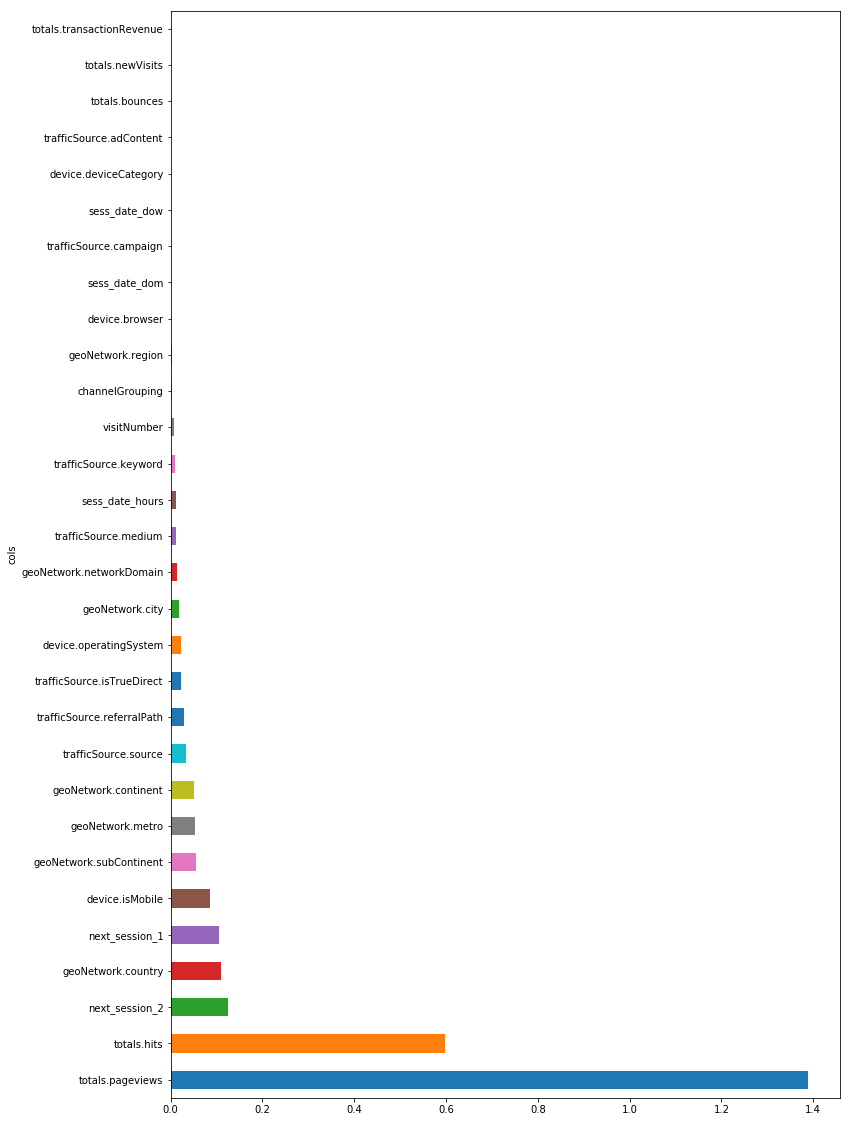

In [21]:
fi = nn_feat_importance(m, md, cat_cols, num_cols)
fi.plot('cols', 'imp', 'barh', figsize=(12,20), legend=False)

# Create user level predictions

In [22]:
np.log1p(result_train).mean(), np.log1p(result_test).mean(), np.log1p(train_indexed['totals.transactionRevenue']).mean()

(0.2715053150869271, 0.21158325964707095, 0.2271182)

In [23]:
#test['PredictedLogRevenue'] = result_test 

In [24]:
#test_grouped = test.groupby(['fullVisitorId'], as_index=False).agg({'PredictedLogRevenue':'sum'})

In [25]:
#test_grouped['PredictedLogRevenue'] = np.log1p(test_grouped['PredictedLogRevenue'])

In [26]:
#csv_fn=f'{PATH}submission.csv'

#test_grouped[['fullVisitorId','PredictedLogRevenue']].to_csv(csv_fn, index=False)

In [27]:
X_indexed['predictions'] = result_train
X_test_indexed['predictions'] = result_test

In [28]:
train_user = X_indexed[cat_cols + num_cols + ['predictions']]
test_user = X_test_indexed[cat_cols + num_cols + ['predictions']]

In [29]:
train_user.reset_index().to_feather('Dataframes/train_user_validated')
test_user.reset_index().to_feather('Dataframes/test_user_validated')

In [30]:
train_user = pd.read_feather('Dataframes/train_user_validated')
test_user = pd.read_feather('Dataframes/test_user_validated')

In [31]:
excluded_features = [
    'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 
    'visitId', 'visitStartTime', 'date'
    #excluded after feature importance:
]

cat_cols = [
    _f for _f in train_user.columns
    if (_f not in excluded_features) & (train_user[_f].dtype.name == 'category')
]

num_cols = [c for c in train_user.columns if c not in cat_cols and c not in excluded_features]

In [32]:
train_user_fact = train_user.copy()
test_user_fact = test_user.copy()
for f in cat_cols:
    train_user_fact[f], indexer = pd.factorize(train_user[f])
    test_user_fact[f] = indexer.get_indexer(test_user[f])

ValueError: buffer source array is read-only

In [ ]:
'''%%time

# Create a list of predictions for each Visitor
#trn_pred_list = train_user[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()

trn_pred_list = train_user_fact[['predictions']].groupby(train_user_fact.index)\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

trn_data = train_user_fact[cat_cols + num_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()

trn_all_predictions1 = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions1.columns

trn_all_predictions = pd.DataFrame(index=trn_data.index)
trn_all_predictions['t_mean']    = trn_all_predictions1[trn_feats].mean(axis=1)
trn_all_predictions['t_median']  = trn_all_predictions1[trn_feats].median(axis=1)
trn_all_predictions['t_sum_log'] = trn_all_predictions1[trn_feats].sum(axis=1)
trn_all_predictions['t_sum_act'] = trn_all_predictions1[trn_feats].fillna(0).sum(axis=1)
trn_all_predictions['t_nb_sess'] = trn_all_predictions1[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions1
gc.collect()
full_data.shape'''

In [ ]:
trn_data = train_user_fact[cat_cols + num_cols].groupby(train_user_fact.index).mean()

In [ ]:
trn_all_predictions = pd.DataFrame(index=trn_data.index)

def create_prediction_mean(train_user):
    '''
    >>> df = create_prediction_mean(pd.DataFrame([3,1],columns=['predictions'], index=[1,1]))
    >>> df
       predictions
    1            2
    '''
    pass
    return train_user[['predictions']].groupby(train_user.index).mean()
    
doctest.testmod()

#create_prediction_mean(train_user_fact)

In [ ]:
trn_all_predictions['t_mean']

In [ ]:
trn_all_predictions = create_prediction_mean

trn_all_predictions['t_median']  = train_user[['predictions']].groupby(train_user_fact.index).median()

trn_all_predictions['t_sum_log'] = train_user[['predictions']].groupby(train_user_fact.index).sum()

trn_all_predictions['t_count'] = train_user[['predictions']].groupby(train_user_fact.index).count()

In [ ]:
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)

In [ ]:
'''%%time
sub_pred_list = test_user[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})'''

In [ ]:
'''sub_data = test_user_fact[cat_cols + num_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()

sub_all_predictions1 = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)

for f in trn_feats:
    if f not in sub_all_predictions1.columns:
        sub_all_predictions1[f] = np.nan

sub_all_predictions = pd.DataFrame(index=sub_data.index)
sub_all_predictions['t_mean']    = sub_all_predictions1[trn_feats].mean(axis=1)
sub_all_predictions['t_median']  = sub_all_predictions1[trn_feats].median(axis=1)
sub_all_predictions['t_sum_log'] = sub_all_predictions1[trn_feats].sum(axis=1)
sub_all_predictions['t_sum_act'] = sub_all_predictions1[trn_feats].fillna(0).sum(axis=1)
sub_all_predictions['t_nb_sess'] = sub_all_predictions1[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape'''

In [ ]:
sub_data = test_user_fact[cat_cols + num_cols].groupby(test_user_fact.index).mean()

In [ ]:
%%time

sub_all_predictions = pd.DataFrame(index=trn_data.index)
print('sub_all_predictions done')
sub_all_predictions['t_mean']    = test_user_fact[['predictions']].groupby(test_user_fact.index).mean()
print('mean done')
sub_all_predictions['t_median']  = test_user_fact[['predictions']].groupby(test_user_fact.index).median()
print('median done')
sub_all_predictions['t_sum_log'] = test_user_fact[['predictions']].groupby(test_user_fact.index).sum()
print('sum done')
sub_all_predictions['t_count'] = test_user_fact[['predictions']].groupby(test_user_fact.index).count()
print('count done')

#sub_all_predictions[['t_mean', 't_median', 't_sum_log', 't_count']].fillna(0, inplace=True)

In [ ]:
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)

In [ ]:
sub_full_data.isna().sum()

In [ ]:
train_user['target'] = yl
trn_user_target = train_user[['target']].groupby(train_user.index).sum()

In [ ]:
for f in full_data.columns:
    print(f +  " - " + str(full_data[f].dtype))

In [ ]:
for v in cat_cols:
    print(v)
    full_data[v] = full_data[v].astype('category').cat.as_ordered()
    

full_data['t_count'] = full_data['t_count'].astype('category').cat.as_ordered()

In [ ]:
apply_cats(sub_full_data, full_data)
#if this does not work it is probably because of a duplicated column name ( throws dataframe has no attribute dtype error)

## Create Dataframes for deep-learning

In [ ]:
full_data['totals.transactionRevenue'] = trn_user_target['target']
sub_full_data['totals.transactionRevenue'] = 0

In [ ]:
full_data.shape, sub_full_data.shape

In [ ]:
#full_data = full_data.apply(lambda x: pd.to_numeric(x, downcast='float') if x.dtype == "float64" else x)

In [ ]:
#sub_full_data = sub_full_data.apply(lambda x: pd.to_numeric(x, downcast='float') if x.dtype == "float64" else x)

In [ ]:
full_data.reset_index().to_feather('Dataframes/full_data')
sub_full_data.reset_index().to_feather('Dataframes/sub_full_data')

In [ ]:
full_data = pd.read_feather('Dataframes/full_data')
sub_full_data = pd.read_feather('Dataframes/sub_full_data')

In [ ]:
excluded_features = [
    'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 
    'visitId', 'visitStartTime', 'date'
    #excluded after feature importance:
]

cat_cols = [
    _f for _f in full_data.columns
    if (_f not in excluded_features) & (full_data[_f].dtype.name == 'category')
]

num_cols = [c for c in full_data.columns if c not in cat_cols and c not in excluded_features]

In [ ]:
import warnings; warnings.simplefilter('ignore')

def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

In [ ]:
cat_sz_user = [(c, len(full_data[c].cat.categories)+1) for c in cat_cols]
cat_sz_user

In [ ]:
emb_sz_user = [(c, max(10, min(50, (c+1)//2))) for _,c in cat_sz_user]
emb_sz_user

In [ ]:
len(df.columns), len(df_test.columns)

In [ ]:
len(df.columns), len(df_test.columns), set(df_test.columns).difference(set(df.columns))

In [ ]:
sub_full_data[['t_mean', 't_median', 't_sum_log']].fillna(0, inplace=True)

In [ ]:
sub_full_data.isna().sum()

In [ ]:
full_data.shape

In [ ]:
folds = GroupKFold(n_splits=5)

result_train_user = np.zeros(full_data.shape[0])
result_test_user = np.zeros(sub_full_data.shape[0])

df, y_user, nas, mapper = proc_df(full_data, 'totals.transactionRevenue', do_scale=True)

for fold_, (trn_, val_) in enumerate(folds.split(df, y_user, df.index)):
    print("Fold:",fold_)
    
    trn_x = full_data.iloc[np.concatenate((trn_, val_), axis=0)]
    val_idx = val_

    df, y_user, nas, mapper_fold = proc_df(trn_x, 'totals.transactionRevenue', do_scale=True, mapper=mapper, na_dict=nas)
    
    df_test, _, nas, mapper = proc_df(sub_full_data, 'totals.transactionRevenue', do_scale=True, 
                                  mapper=mapper_fold, na_dict=nas)
    
    df, y_user, nas, mapper_fold = proc_df(trn_x, 'totals.transactionRevenue', do_scale=True, mapper=mapper, na_dict=nas)
    
    
    #df_test.drop(['device.isMobile_na', 't_mean_na', 't_median_na', 'totals.hits_na', 'visitNumber_na'], axis=1, inplace=True)
 
    yl_user = np.log1p(y_user)
    
    max_y_user = np.max(yl_user)

    y_range_user = (0, max_y_user*1.2)
    
    md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl_user, cat_flds=cat_cols, bs=512, test_df=df_test)
    m = md.get_learner(emb_sz_user, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001, 0.01], y_range=y_range_user)
    
    m.fit(1e-4, 4, cycle_len = 1, cycle_mult = 1, metrics=[exp_rmse])
    
    log_preds_train = m.predict_dl(m.data.trn_dl)
    log_preds_val = m.predict_dl(m.data.val_dl)
    log_preds_train[log_preds_train < 0] = 0
    log_preds_val[log_preds_val < 0] = 0
    result_train_user[trn_] = np.expm1(log_preds_train).reshape(-1)
    result_train_user[val_] = np.expm1(log_preds_val).reshape(-1)
        
    log_preds_test = m.predict(True)
    log_preds_test[log_preds_test < 0] = 0
    result_test_user += (np.expm1(log_preds_test) / folds.n_splits).reshape(-1)
    
    del(df)
    del(df_test)
    gc.collect()

In [ ]:
len(df.columns), len(df_test.columns), set(df_test.columns).difference(set(df.columns))

## Learning Rate finder

# Create Submission 

In [ ]:
result_train_user.mean(), result_test_user.mean(), y_user.mean(), y.mean()

In [ ]:
submission = sub_full_data.copy()

In [ ]:
submission['PredictedLogRevenue'] = result_test_user

In [ ]:
csv_fn=f'{PATH}submission.csv'

submission_grouped[['fullVisitorId','PredictedLogRevenue']].to_csv(csv_fn, index=False)

submission_grouped